# DSCI 100 Haiyu Long Individual Stage
# Study Question: Will the players' gaming experience, whether or not they subscribe to the game-related newsletter, and age become useful predictors for their total hours of playing?

We will start by loading the most correlated dataset players.csv.

In [2]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [4]:
players <- read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


From this dataset, we can find several columns, where each row represents a single player's data. There are 196 players (rows) in the dataset, each with seven columns describing specific information.

- The "experience" section indicates the player's level of proficiency in the game, divided into five categories: "beginner," "regular," "Amateur," "veteran" and "pro."
- This is followed by the 'subscribe' column, which shows if the player has a habit of subscribing to news related to the game.
- The next column is the email address of the hashed player.
- The 'played hour' column measures each player's play time on an hour basis.
- The last three columns mark the player's name, gender, and age.

We find that, except for play_hours and age, which are stored as doubles, and subscribe, which are stored as logical vectors, the rest of the columns are stored as strings in the dataset.
In the columns above, we focus on the metrics' experience ', 'subscribe', and 'age' and the response variable 'played_hours'. We try to analyze whether the first three indicators have a sufficient data correlation with the latter to qualify as predictors.

Next, we will do a basic collation of the data set and identify potential problems in the data set that may hinder our analysis.

In [16]:
players_mdfied <- players |>
    select(-hashedEmail) |> #remove the obvious not useful column
    mutate(experience = as_factor(experience)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE")) #factorize two important column for later analysis

players_na_sum <- colSums(is.na(players_mdfied))

players_mdfied
players_na_sum

experience,subscribe,played_hours,name,gender,Age
<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>
Pro,Yes,30.3,Morgan,Male,9
Veteran,Yes,3.8,Christian,Male,17
Veteran,No,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮
Amateur,No,0.0,Dylan,Prefer not to say,17
Amateur,No,2.3,Harlow,Male,17
Pro,Yes,0.2,Ahmed,Other,NA


experience    subscribe played_hours         name       gender          Age 
           0            0            0            0            0            2

After sorting out the data, we found that two na values appeared in the age column. Due to the small number of NA values, we can consider directly discarding these two rows of data for the time being. In other words, we will apply na.rm in all following data summarize and visualization sections. 
Next, we will make a summary analysis for each columns in the dataset.

In [23]:
hours_played_summary <- players_mdfied |> summarize(played_hours_min = min(played_hours, na.rm = TRUE),
    played_hours_max = max(played_hours),
    played_hours_mean = mean(played_hours),
    played_hours_median = median(played_hours),
    played_hours_sd = sd(played_hours))

age_summary <- players_mdfied |> summarize(age_min = min(Age, na.rm = TRUE),
    age_max = max(Age, na.rm = TRUE),
    age_mean = mean(Age, na.rm = TRUE),
    age_median = median(Age, na.rm = TRUE))

ctg_summary <- players_mdfied |>
  select(experience, subscribe, gender) |>
  pivot_longer(cols = experience:gender, names_to = "Column", values_to = "categories") |>
  group_by(Column, categories) |>
  summarize(Count = n())

hours_played_summary
age_summary
print(ctg_summary)

`summarise()` has grouped output by 'Column'. You can override using the
`.groups` argument.


played_hours_min,played_hours_max,played_hours_mean,played_hours_median,played_hours_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,223.1,5.845918,0.1,28.35734


age_min,age_max,age_mean,age_median
<dbl>,<dbl>,<dbl>,<dbl>
8,50,20.52062,19


# A tibble: 14 × 3
# Groups:   Column [3]
   Column     categories        Count
   <chr>      <chr>             <int>
 1 experience Amateur              63
 2 experience Beginner             35
 3 experience Pro                  14
 4 experience Regular              36
 5 experience Veteran              48
 6 gender     Agender               2
 7 gender     Female               37
 8 gender     Male                124
 9 gender     Non-binary           15
10 gender     Other                 1
11 gender     Prefer not to say    11
12 gender     Two-Spirited          6
13 subscribe  No                   52
14 subscribe  Yes                 144


From the above statistics, we can find a lot of interesting information.

The minimum value of play time is 0, which means that some players registered an account but did not play. Comparing the maximum with the mean and the median also shows that there may be a large number of players who play less than two hours or even less than an hour. Based on the age statistics, we found that most players are probably still young adults (15-35).

Finally, in terms of player proficiency, apart from the fact that the number of pro players is relatively small (which is also common sense), the number of skilled players is fairly evenly distributed. At the same time, more than half of the data in the entire dataset was contributed by male players. Among the players, most of them have subscribed to the newsletter related to the game.

These statistics will provide hints for our subsequent analysis and suggest that our conclusions may be very limited. For example, data composed mostly of male players may indicate that our conclusions are only applicable to male players.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


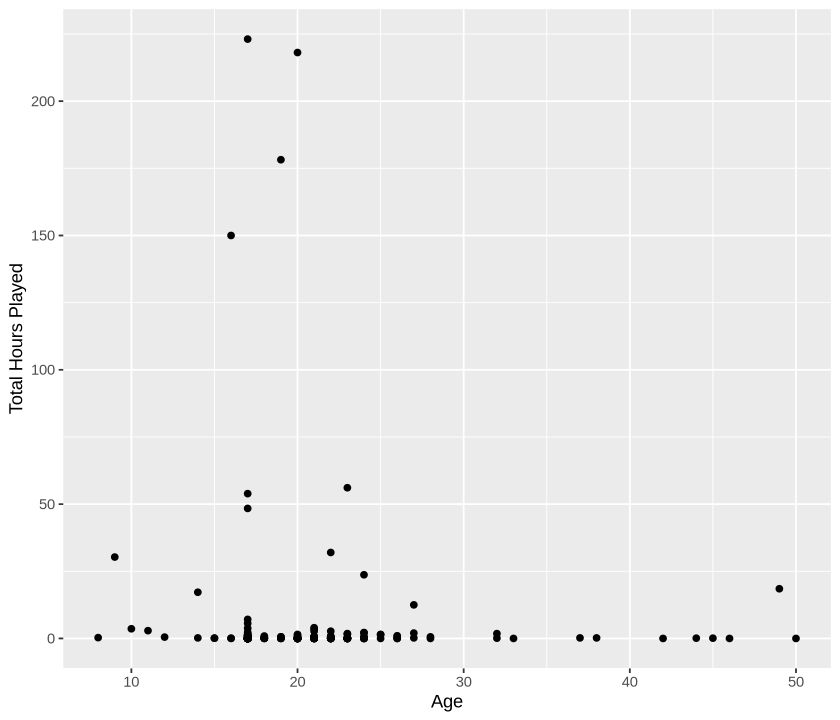

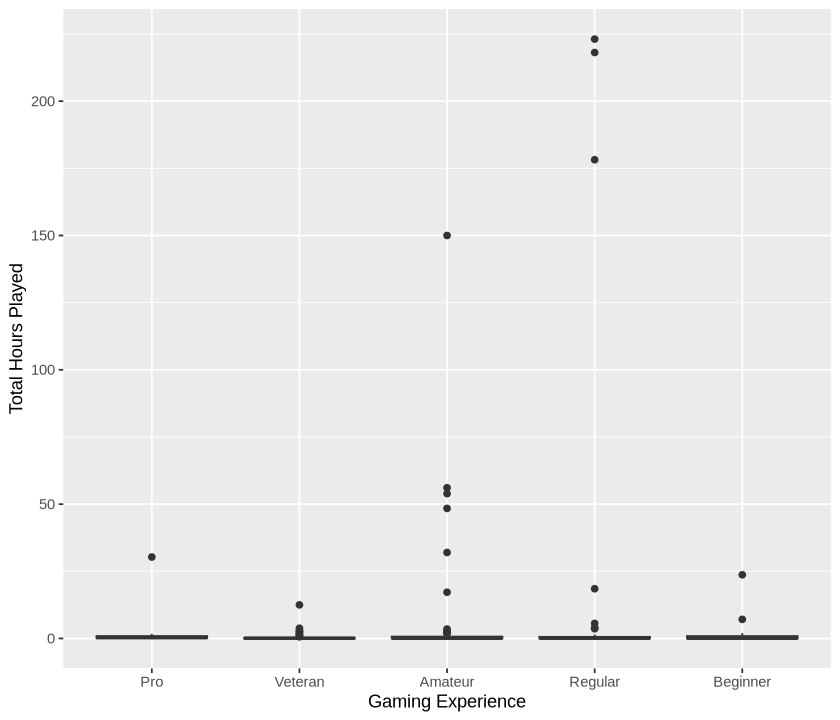

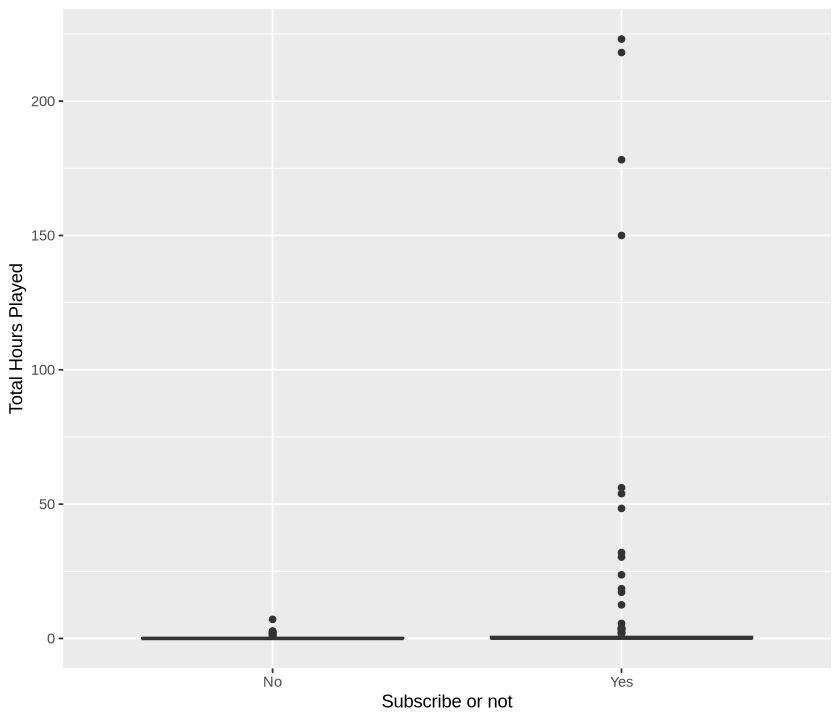

In [37]:
options(repr.plot.height = 6, repr.plot.width = 7)

age_hours_plot <- ggplot(players_mdfied, aes(x = Age, y = played_hours)) +
  geom_point() +
  labs(x = "Age", y = "Total Hours Played")

exp_hours_plot <- ggplot(players_mdfied, aes(x = experience, y = played_hours)) +
  geom_boxplot() +
  labs(x = "Gaming Experience", y = "Total Hours Played")

subs_hours_plot <- ggplot(players_mdfied, aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(x = "Subscribe or not", y = "Total Hours Played")

age_hours_plot
exp_hours_plot
subs_hours_plot

# Methods and plans

We plan to use a multifactor linear regression model as a preliminary prediction tool, using players' gaming experience, whether they subscribe to newsletters, and age to predict the total amount of time a player will play.

First, the linear regression model is suitable for predicting continuous response variables (such as total play time), and can handle both numerical variables (age) and categorical variables (experience and subscription after factoring and numericalized).

Analytical presupposition
- Assume a linear relationship between each predictor and response variable.
- Need to convert character variables to factors or numerical numbers (0 or 1).

Potential limitations or weaknesses
- If there are nonlinear relationships or significant interactions between the predictor and response variables, a simple linear model may not be sufficient to capture these complex relationships.
- The current dataset may not collect all the important factors that affect the game duration, thus reducing the explanatory power.

project
1. Check and clean the data (dealing with missing values and outliers).
2. Convert character variables (such as experience and subscribe) into factors and construct dummy variables if necessary.
3. Split the data set into training set and test set. The recommended ratio is 70% training set and 30% test set.
4. In the training stage, cross-validation is used to further adjust the model parameters to ensure that the model has good generalization performance on the unseen data.
5. Use k-fold cross-validation (5 or 10 fold) to evaluate the model's performance on the training set to prevent overfitting or underfitting.